# Interacting with the Retrieval-Augmented Generation (RAG) Onna API

Welcome to this Jupyter notebook guide on using the Retrieval-Augmented Generation (RAG) in Onna Platform API, a powerful tool that combines the strengths of retrieval and generation models to enhance natural language understanding and generation. In this tutorial, we'll explore the fundamentals of RAG and demonstrate how to interact with the Onna Platform API to generate contextually rich and coherent text.


## Understanding RAG

### What is RAG?
Retrieval-Augmented Generation (RAG) is an innovative approach in natural language processing that synergizes the strengths of retrieval and generation models. By combining information retrieval with generative language models, RAG achieves a balance between context enrichment and coherent text generation.

### Key Features:

- Context Enrichment: RAG leverages a retrieval model to fetch relevant information, enriching the context available for text generation.

- Factuality and Consistency: The retrieval component enhances the model's ability to provide factual and consistent information by leveraging a knowledge base.

- Reduced Open-endedness: RAG addresses the challenge of open-endedness in purely generative models, providing more specific and relevant responses.

## Prerequisites

Before getting started, make sure you have the following:
- OpenAI developer account with a valid API-KEY. You can find your OpenAI keys [here](https://platform.openai.com/api-keys).
- An Onna account. Tutorial [how to create a sandbox account](https://dev.onna.com/get-started/sandbox) and [how to generate Onna Platform api keys](https://dev.onna.com/get-started/authentication).

### Installation

Install python dependencies

In [ ]:
%%bash

pip install requests
pip install tuspy

If everything has been installed correctly you can now import the necessary python libraries.

In [57]:
import requests
from tusclient.client import TusClient

### Manage credentials

To securely store API credentials and other sensitive information in Google Colab, it's recommended to Google Colab secrets.

The secrets manager is represented by a key icon in the left panel.

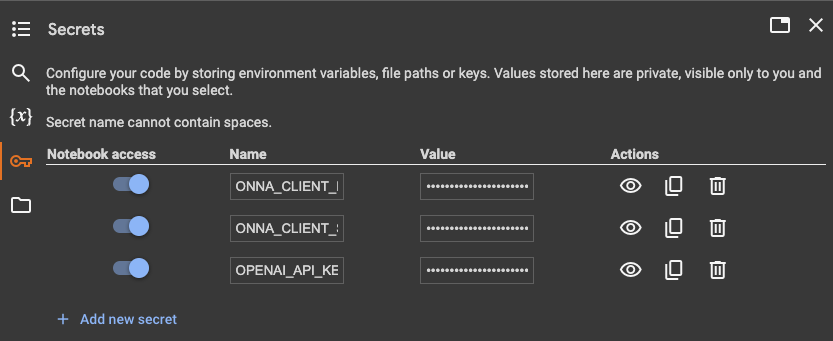

You must define the secrets as follows:

**`ONNA_CLIENT_ID`:**
   - *Definition:* The client identifier associated with your user account in the Onna platform. It is used as a key to uniquely identify and authenticate your application when interacting with the API.

**`ONNA_CLIENT_SECRET`:**
   - *Definition:* The client secret associated with your user account in the Onna platform. It serves as a confidential key used for secure communication between your application and the API. Keep it confidential to ensure the security of your interactions.

**`OPENAI_API_KEY`:**
   - *Definition:* The API key associated with the external service that will be used internally to generate responses. This key acts as a form of authentication and authorization, allowing your application to access the functionalities of the external service securely.


Make sure the credentials have Notebook access enabled.

In [ ]:
from google.colab import userdata

ONNA_CLIENT_ID = userdata.get("ONNA_CLIENT_ID")
ONNA_CLIENT_SECRET = userdata.get("ONNA_CLIENT_SECRET")
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
print("The secrets have been loaded correctly")

try:
    BASE_URL = userdata.get("BASE_URL")
except userdata.SecretNotFoundError:
    BASE_URL = "https://api.onna.com/v1"
print("Using the base url:", BASE_URL)


In [ ]:
# Login
url = f"{BASE_URL}/oauth/token"
payload = f"client_id={ONNA_CLIENT_ID}&client_secret={ONNA_CLIENT_SECRET}&grant_type=client_credentials"
login_headers = {'Content-Type': 'application/x-www-form-urlencoded',}
response = requests.post(url, headers=login_headers, data=payload)
assert response.status_code == 200
token = response.json()["access_token"]
print("Login success")

**NOTE:** If you have any error make sure your `ONNA_CLIENT_ID` and `ONNA_CLIENT_SECRET` are valid.



In [60]:
# Define the Onna Platform API authentication headers
headers = {"Authorization": f"Bearer {token}"}

This header must be used for every interaction with the Onna Platform API.

Let's create the workspace and the folder where we are going to upload the files. It's important to create the workspace with the `embeddings_enabled` attribute as `True`.

In [ ]:
# Create a workspace with embeddings calculation enabled
payload = {
    "name": "Workspace with embeddings calculation enabled",
    "embeddings_enabled": True,
}
url = f"{BASE_URL}/workspaces"
response = requests.post(url, headers=headers, json=payload)
workspace_id = response.json()["onna_id"]
print("Workspace created correctly with the id:", workspace_id)

# Create a foler inside the workspace
payload = {
    "onna_parent_id": workspace_id,
    "name": "Folder that will contain the files context to use for the RAG",
}
url = f"{BASE_URL}/folders"
response = requests.post(url, headers=headers, json=payload)
folder_id = response.json()["onna_id"]
print("Folder created correctly with the id:", folder_id)

In preparation for the test, we will be downloading specific pages from the Onna blog and Onna webpage to serve as context for the RAG (Retrieval-Augmented Generation) for the Large Language Model (LLM). This approach is aimed at providing the model with a rich source of information to enhance its understanding and generation capabilities.



In [ ]:
tmp_dir = "/tmp"
documents = [
  {
      "name": "Onna Blog - RAG",
      "url": "https://onna.com/blog/what-is-retrieval-augmented-generation"
  },
  {
      "name": "Onna AI data pipeline",
      "url": "https://onna.com/ai-data-pipeline"
  },
]


# Download some web pages from Onna blog
for doc in documents:
    response = requests.get(doc["url"])
    with open(f"{tmp_dir}/{doc['name']}.html", "wb") as file:
        file.write(response.content)

# Upload the data files to Onna
file_ids = []
for doc in documents:
    payload = {
        "onna_parent_id": folder_id,
        "ref": doc["name"],
        "name": doc["name"],
        "url": doc["url"]
    }
    url = f"{BASE_URL}/resources/files"
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 409:
      print(f"The ref attribiute must be unique in the folder. The attribute ref in the {payload} already exists in the {folder_id} folder")
      continue
    elif response.status_code != 201:
      print("Error creating the file")
      continue

    file_id = response.json()["onna_id"]
    tus_client = TusClient(
        f"{BASE_URL}/upload/{file_id}/tus", headers=headers,
    )
    uploader = tus_client.uploader(
        f"{tmp_dir}/{doc['name']}.html",
        metadata={"name": f"{doc['name']}.html"},  # The name is IMPORTANT to determine the extension
        chunk_size=1024 * 1024 * 1,  # 1MB
    )
    uploader.upload()
    file_ids.append(file_id)
    print(f"The file '{doc['name']}' has been uploaded successfully.")

**NOTE:** The `ref` attribute must be unique for each file uploaded to this folder. If we attempt to upload a file with the same `ref` attribute, the server will return an error.

In [ ]:
# Wait until all files are processed
import time

timeout = 60  # seconds
processed_files = []
start_time = time.time()
while True:
    for file_id in file_ids:
        if file_id in processed_files:
            continue
        url = f"{BASE_URL}/resources/files/{file_id}"
        response = requests.get(url, headers=headers)
        if response.json()["processing_date"]:
            print(f"File {file_id} it's been process")
            processed_files.append(file_id)

    if len(file_ids) == len(processed_files):
        break

    if time.time() - start_time > timeout:
        raise Exception('Timeout exceeded while waiting for files to be processed')

    time.sleep(5)

In [64]:
# Function to query the rag endpoint
def rag_query(query, context_ids, wallet_id, token):
    payload = {
        "query": query,
        "context_ids": context_ids,
        "wallet_id": wallet_id,
    }
    headers = {"Authorization": f"Bearer {token}"}
    url = f"{BASE_URL}/rag/query"
    response = requests.post(url, headers=headers, json=payload)
    assert response.status_code == 200, f"Invalid status code: {response.status_code}"
    return response.json()

In [65]:
# Create the wallet credentials
payload = {
    "name": "Open API Wallet entry",
    "credentials": OPENAI_API_KEY,
}
headers = {"Authorization": f"Bearer {token}"}
url = f"{BASE_URL}/wallet"
response = requests.post(url, headers=headers, json=payload)
assert response.status_code == 201, f"Invalid status code: {response.status_code}"
wallet_id = response.json()["onna_id"]

In [66]:
response = rag_query(
    query="How does Retrieval-Augmented Generation work?",
    context_ids=[workspace_id],
    wallet_id=wallet_id,
    token=token,
)

The response to the question is:

In [ ]:
print(response["response"])
for reference in response["references"]:
    print(reference)

In [ ]:
# Create the an empty workspace
payload = {
    "name": "Empty workspace that does not contain any documents",
    "embeddings_enabled": True,
}
url = f"{BASE_URL}/workspaces"
response = requests.post(url, headers=headers, json=payload)
empty_workspace_id = response.json()["onna_id"]

# Make a query using the empty workspace as a context
response = rag_query(
    query="How does Retrieval-Augmented Generation work?",
    context_ids=[empty_workspace_id],
    wallet_id=wallet_id,
    token=token,
)

print(response["response"])